In [452]:
import numpy as np
import random as rd
from tqdm import tqdm
import matplotlib.pyplot as plt

Question 1

In [2]:
def relu(x):

    val = x.copy()
    grad = x.copy()
    for i in range(len(x)):
        if val[i]<0:
            val[i]=0
            grad[i]=0
        else:
            grad[i]=1
    
    def vjp(u):
        vjp_wrt_x = u*grad
        return vjp_wrt_x


    return val,vjp,grad

In [3]:
x = np.array([2])

val, vjp,grad = relu(x)

eps=0.01

df = (relu(x+eps)[0] - relu(x)[0])/eps

u = np.array([5])

print(vjp(u))

print(u*df)

[5]
[5.]


Question 2

In [4]:
def dot(W, x):
    value = np.dot(W, x)

    def vjp(u):
        return np.outer(u, x), W.T.dot(u)

    return value, vjp


In [5]:
def mlp2(x,W1,W2):

    x2,vjp_relu1,grd_relu1 = relu(dot(W1,x)[0])

    value,vjp_relu2,grd_relu2  = relu(dot(W2,x2)[0])


    def vjp(u):
        vjp_x = vjp_relu2*W2.T*grd_relu1*W1
        vjp_W1 = vjp_relu2*W2.T*grd_relu1*x
        vjp_W2 = vjp_relu2*x2
        
        return vjp_x,vjp_W1,vjp_W2
    
    grad = [grd_relu2*W2*grd_relu1*W1,grd_relu2*W2*grd_relu1*x,grd_relu2*x2]

        
    
    return value,vjp,grad

In [6]:
x = np.array([1,2])
W1 = np.array([[1,1],[1,1]])
W2 = np.array([[2,2],[2,2]])
print(mlp2(x,W1,W2))

(array([12, 12]), <function mlp2.<locals>.vjp at 0x00000280FF1A5240>, [array([[2, 2],
       [2, 2]]), array([[2, 4],
       [2, 4]]), array([3, 3])])


Question 3

In [11]:
def squared_loss(y_pred, y):
    residual = y_pred - y
    
    grad_y_pred = np.sum(residual)
    grad_y = -np.sum(residual)
    grad = [grad_y_pred,grad_y]
    
    def vjp(u):
        vjp_y_pred = u*grad[0]
        vjp_y = u*grad[1]
        return vjp_y_pred, vjp_y

    value = 0.5 * np.sum(residual ** 2)

    return np.array([value]), vjp, grad


In [12]:
y_pred = np.array([1,2,5,4])
y = np.array([0.5,2,4.3,5.7])

print(squared_loss(y_pred,y))

(array([1.815]), <function squared_loss.<locals>.vjp at 0x00000280FED90C10>, [-0.5, 0.5])


Question 4

In [13]:
def loss(x, y, W1, W2):

    y_pred,vjp_mlp,grad_mlp = mlp2(x,W1,W2)
    value,vjp_sl,grad_sl = squared_loss(y_pred, y)

    def vjp(u):
        vjp_y_pred, vjp_y = vjp_sl(u)
        [grad_x,grad_w1,grad_w2] = grad_mlp

        vjp_x = vjp_y_pred*grad_x
        vjp_w1 = vjp_y_pred*grad_w1
        vjp_w2 = vjp_y_pred*grad_w2
        
        return vjp_x,vjp_w1,vjp_w2,vjp_y

    return value, vjp

In [14]:
y = np.array([12,13])
print(loss(x,y,W1,W2))

(array([0.5]), <function loss.<locals>.vjp at 0x00000280FF1D2CB0>)


Question 5

In [223]:
def mlp_forward(x,Dico_W): # Dico_W contains the matrices W and the keys are range(N_matrices)
    X = x
    l_grad = []
    l_val = []
    for i in range(len(Dico_W.keys())):
        l_val.append(np.array([X]))
        W = Dico_W[i]
        X = dot(W.T,X)[0]
        X,vjp,grad = relu(X)
        l_grad.append(np.array([grad]))
    
    return X,l_grad,l_val

In [138]:
def loss(x, y, Dico_W):

    y_pred,grad_mlp,val_mlp = mlp_forward(x,Dico_W)
    value,vjp_sl,grad_sl = squared_loss(y_pred, y)
    grad_mlp.append([grad_sl[0]])
    def vjp(u):
        vjp_y_pred, vjp_y = vjp_sl(u)

        l_vjp=[]
        for i in range(len(Dico_W)):
            l_vjp.append(vjp_y_pred*grad_mlp[i])
            
        l_vjp.append(vjp_y)
        return l_vjp

    return value, grad_mlp,val_mlp,vjp

In [466]:
def mlp_backprop(dico_w,grad_l,val_mlp,lr):
    k=len(dico_w)
    dico_w[k] = np.array([[1]])
    k-=1
    a=np.array([grad_l[-1]])
    for i in range(len(grad_l)-2,0,-1):     
        a = (a @ (dico_w[k+1].T)) * grad_l[i]
        dico_w[k]= dico_w[k].astype('float') - lr*((val_mlp[k].T) @ a).astype('float')
        k-=1
    del dico_w[len(dico_w)-1]
    return dico_w

Question 6

In [477]:
def SGD_train(X,Y,Dico_W,lr,epochs=10):
    l_loss=[]
    l_x = list(range(len(X)))
    rd.shuffle(l_x)   # x_choose: list of index of chosen points
    for e in tqdm(range(epochs)):
        for x in l_x:
            l,grad_l,val_mlp,vjp = loss(X[x], Y[x], Dico_W)
            Dico_W = mlp_backprop(Dico_W,grad_l,val_mlp,lr)
        if e%100==0:
            l_loss.append(evaluate(X,Y,Dico_W))
    
    return Dico_W,l_loss


def evaluate(X,Y,Dico_W):
    s=0
    for i in range(len(X)):
        s+=(loss(X[i], Y[i], Dico_W))[0]
    return s/len(X)

[9.38863027]


100%|██████████| 30000/30000 [00:06<00:00, 4873.49it/s]


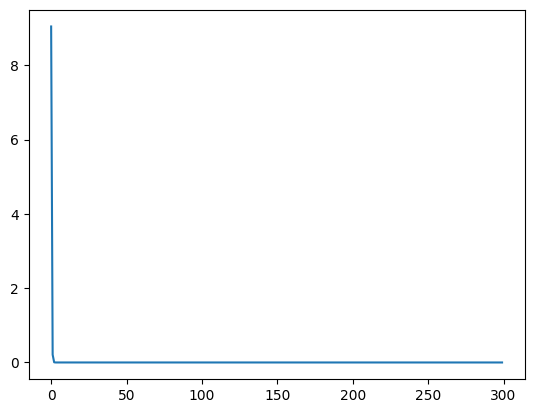

[7.28924358e-05]
3.0 [3.0033031]
6.0 [6.00660619]
20.0 [20.00275094]
8.0 [8.00399083]
5.0 [5.00068773]
5.0 [4.97178317]


In [487]:
x = np.array([[1.,2],[2,4],[8,12],[3,5],[2,3],[4,1]])
y = np.array([3,6,20.,8,5,5])

rd.seed(10000)
w1=np.random.uniform(size=(2,3)).astype('float')
w2 = np.random.uniform(size=(3,1)).astype('float')
w3 = np.random.uniform(size=(2,2)).astype('float')
w4 = np.random.uniform(size=(2,1)).astype('float')
dico_w= {0:w1,1:w2}

print(evaluate(x,y,dico_w))
dico_w2,l_loss = SGD_train(x,y,dico_w,1e-4,epochs=30000)

plt.figure(1)
plt.plot(l_loss)
plt.show()

print(evaluate(x,y,dico_w2))
for i in range(len(x)):
    print(y[i],mlp_forward(x[i],dico_w2)[0])


## one hidlayer : 7.28924358e-05 two:  3.14653699e-09 three: 0.00867924